Make sure the folder is ported

In [ ]:
! cd ./drive/MyDrive/X-Ray/OK_images_jpeg_cropped/ && ls -U | head -4

/bin/bash: line 0: cd: ./drive/MyDrive/X-Ray/OK_images_jpeg_cropped/: No such file or directory


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from PIL import Image
from pathlib import Path
from collections import Counter
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "./drive/MyDrive/X-Ray/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 179 files belonging to 2 classes.
Using 144 files for training.
Found 179 files belonging to 2 classes.
Using 35 files for validation.


In [ ]:
print(train_dataset.file_paths)
print(train_dataset.class_names)
print(dir(train_dataset))

['./drive/MyDrive/X-Ray/OK_images_jpeg_cropped_randomised_brightness_contrast/brightfact_1.8_contrastfact_0.6_cropped_2021-11-02 12-42-46 - recRTB6R0ELD1AJ1 - 8680493071_Az48_0.jpeg', './drive/MyDrive/X-Ray/OK_images_jpeg_cropped_randomised_brightness_contrast/brightfact_0.7_contrastfact_1.3_cropped_2021-11-02 13-38-13 - recRTB6R0ELD1AJ1 - 8680493004_Az29_0.jpeg', './drive/MyDrive/X-Ray/OK_images_jpeg_cropped_randomised_brightness_contrast/brightfact_1.5_contrastfact_0.8_cropped_2021-11-02 11-54-47 - recRTB6R0ELD1AJ1 - 8660535534_Az18_0.jpeg', './drive/MyDrive/X-Ray/bodyply_cropped_grayscale_randomised_brightness_contrast/brightfact_0.5_contrastfact_1.4grayscale_cropped_2021-10-06 21-08-32 - recRLBJKHETA3ALA - 8630336442_Az13_0.jpeg', './drive/MyDrive/X-Ray/OK_images_jpeg_cropped_randomised_brightness_contrast/brightfact_1.7_contrastfact_1.8_cropped_2021-11-02 12-46-35 - recRTB6R0ELD1AJ1 - 8680492996_Az27_0.jpeg', './drive/MyDrive/X-Ray/OK_images_jpeg_cropped_randomised_brightness_cont

./drive/MyDrive/X-Ray/OK_images_jpeg_cropped_randomised_brightness_contrast/brightfact_1.8_contrastfact_0.6_cropped_2021-11-02 12-42-46 - recRTB6R0ELD1AJ1 - 8680493071_Az48_0.jpeg


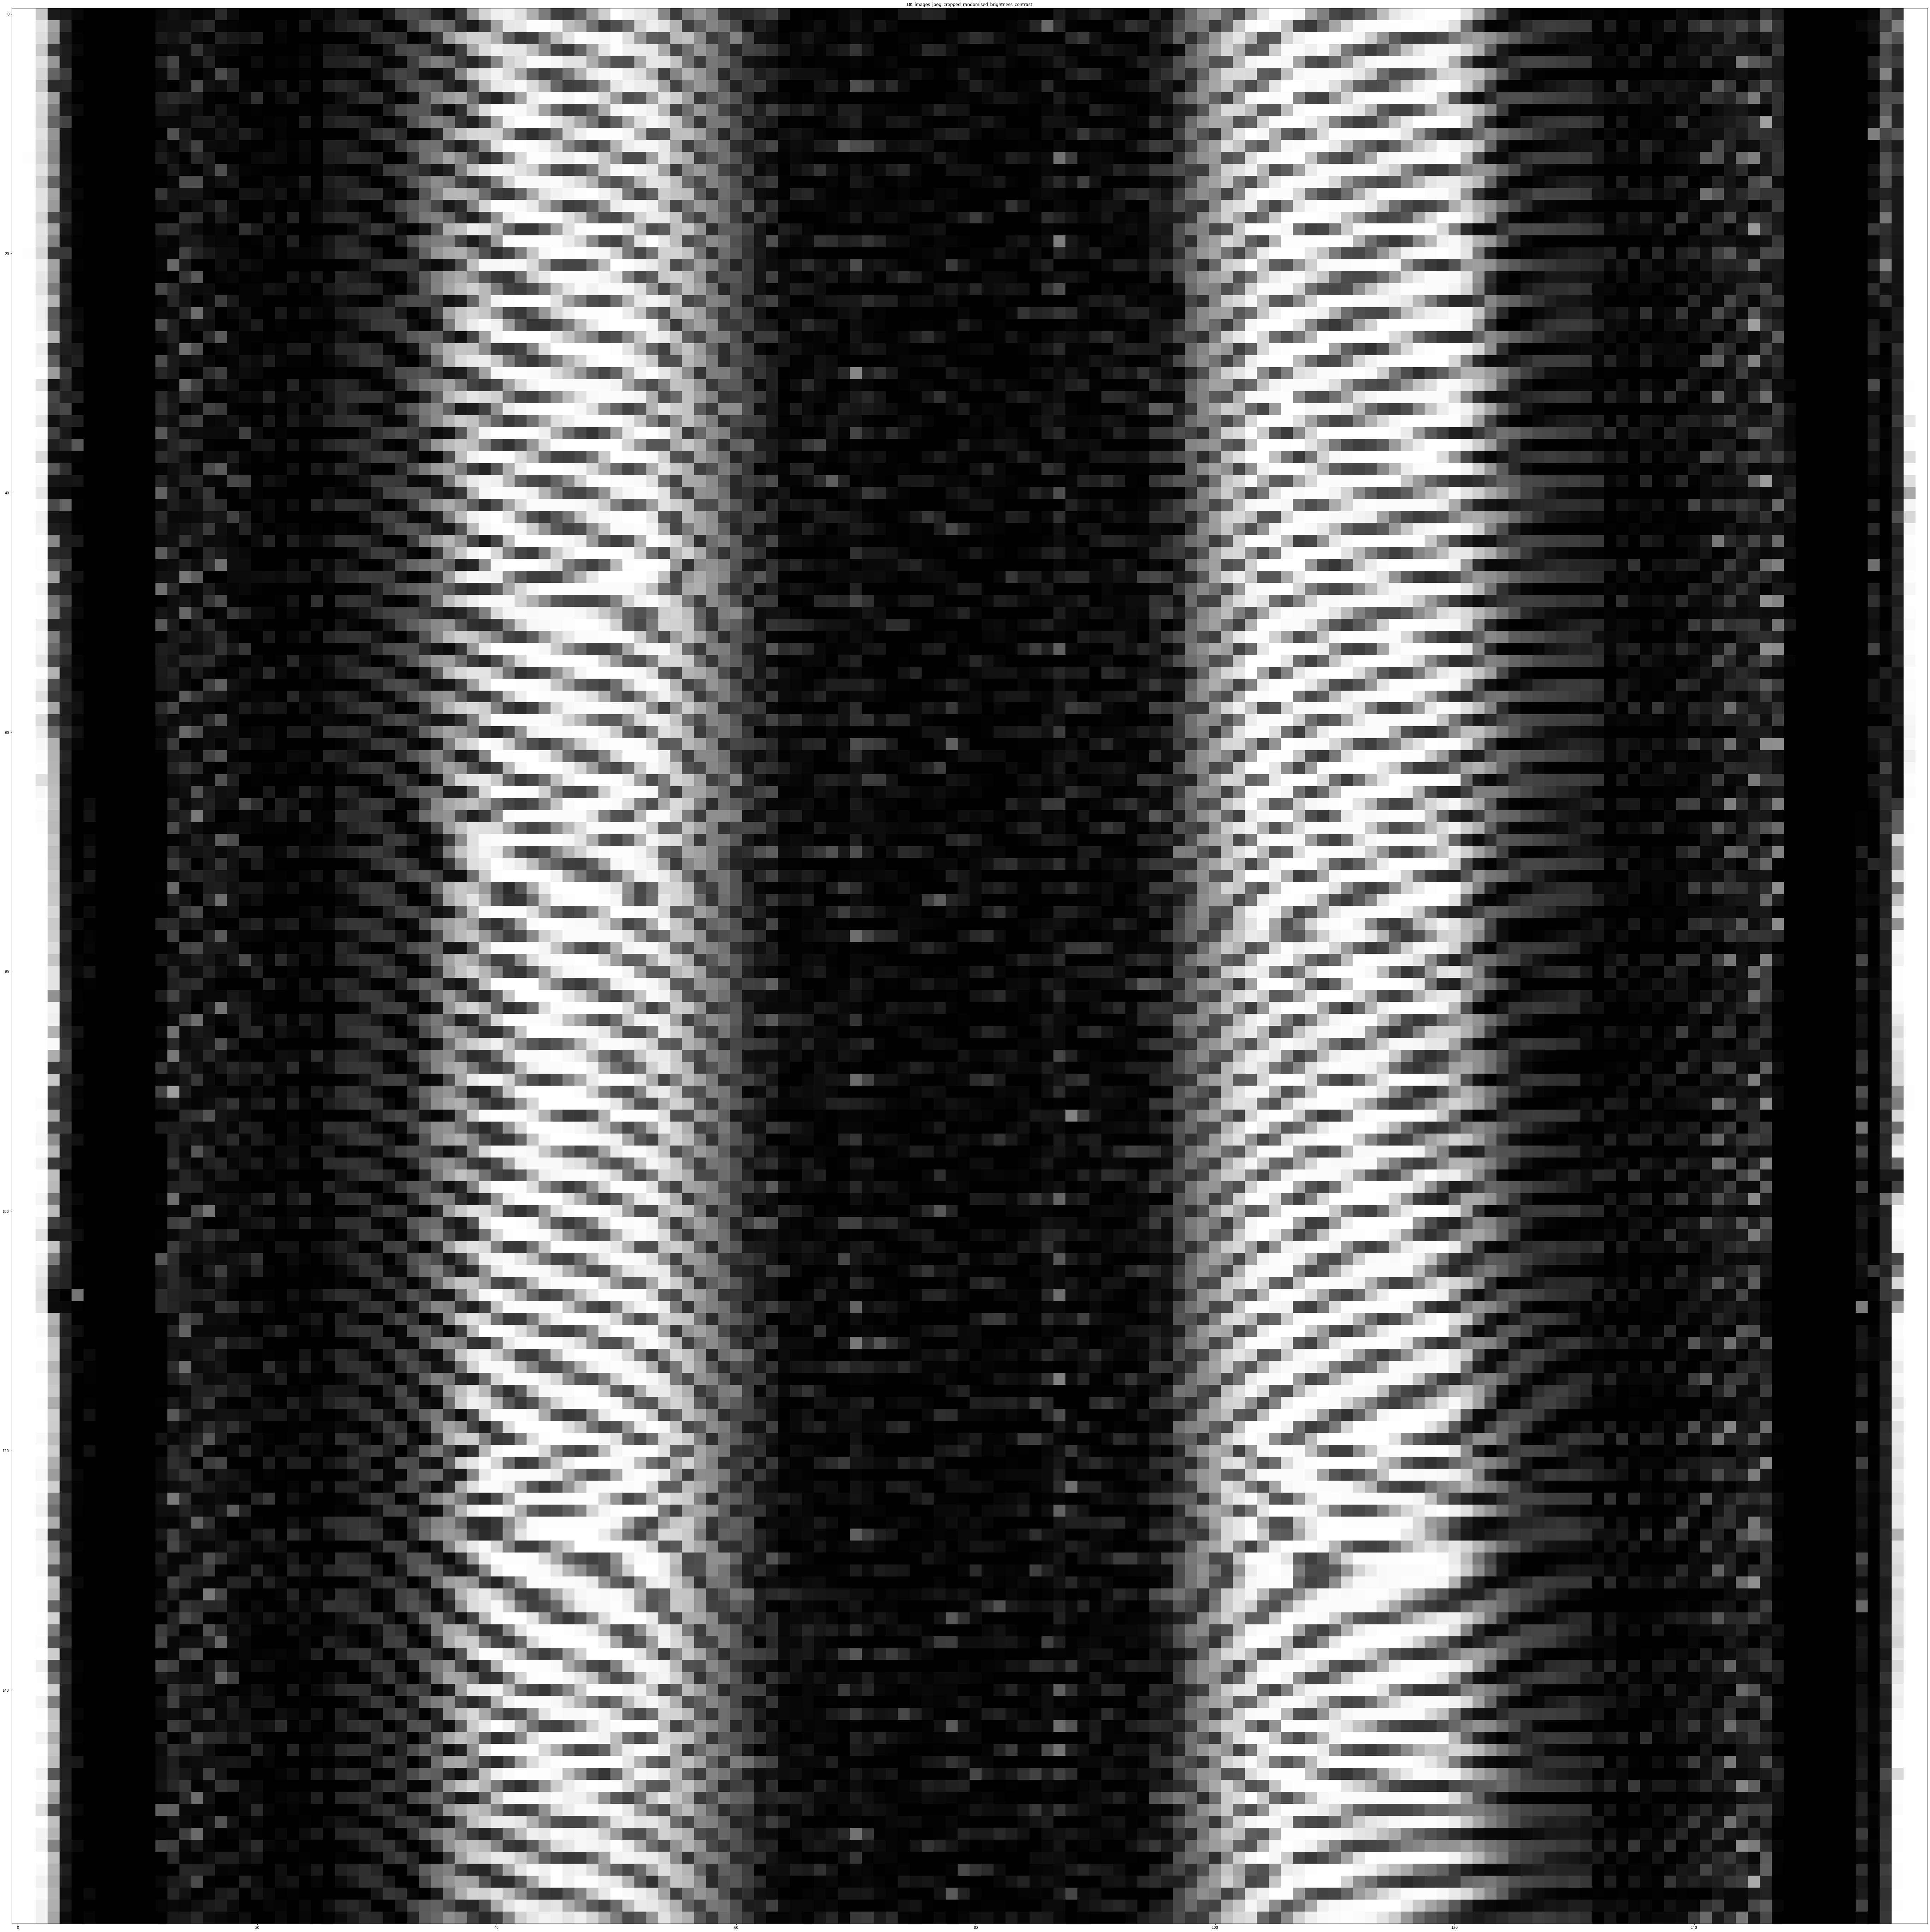

In [ ]:
class_names = train_dataset.class_names
file_paths = train_dataset.file_paths
plt.figure(figsize=(100, 100))
for images, labels in train_dataset.take(1):
  plt.imshow(images[1].numpy().astype("uint8"))
  print(file_paths[labels[1]])
  plt.title(class_names[labels[1]])

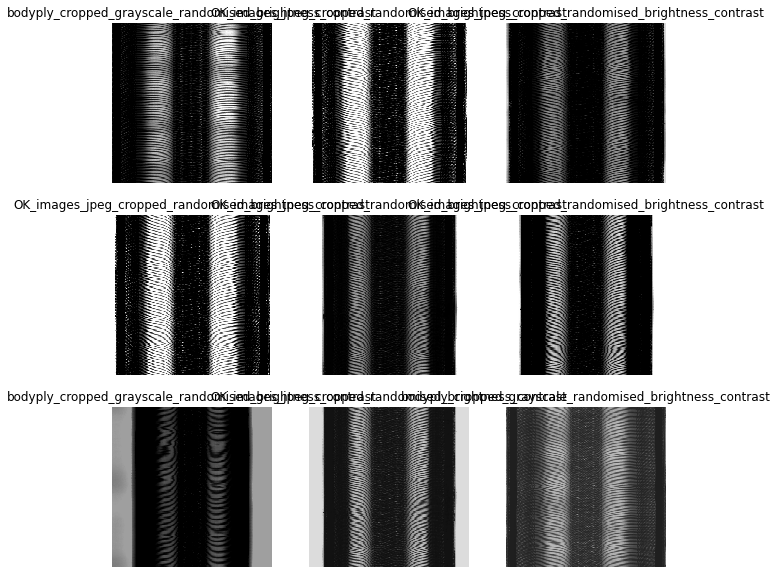

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomFlip('vertical')
    ])
    
    return data_augmentation

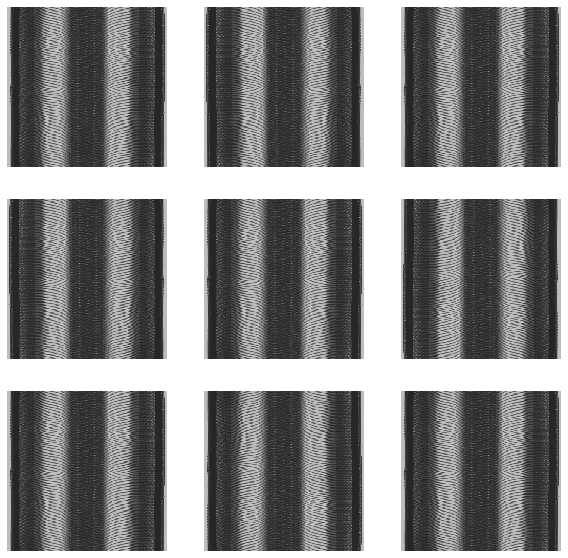

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Normalize input

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


first batch from tensorflow dataset used as  images run through the MobileNetV2 base model

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int32)>

In [ ]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n04209239', 'shower_curtain', 0.45666763),
  ('n04589890', 'window_screen', 0.22562276)],
 [('n04589890', 'window_screen', 0.20324408),
  ('n04590129', 'window_shade', 0.1811905)],
 [('n04589890', 'window_screen', 0.84162277),
  ('n04209239', 'shower_curtain', 0.0781923)],
 [('n04209239', 'shower_curtain', 0.5038307),
  ('n04589890', 'window_screen', 0.32157576)],
 [('n04589890', 'window_screen', 0.7313355),
  ('n04209239', 'shower_curtain', 0.114160344)],
 [('n04589890', 'window_screen', 0.705129),
  ('n04590129', 'window_shade', 0.19921614)],
 [('n04589890', 'window_screen', 0.8282898),
  ('n04590129', 'window_shade', 0.048058007)],
 [('n04589890', 'window_screen', 0.6491933),
  ('n04209239', 'shower_curtain', 0.18603566)],
 [('n03998194', 'prayer_rug', 0.40200794),
  ('n03530642', 'honeycomb', 0.25908595)],
 [('n04590129', 'window_shade', 0.52392864),
  ('n04209239', 'shower_curtain', 0.031324394)],
 [('n04589890', 'window_screen', 0.63341564),
  ('n04209239', 'shower_curtain', 

In [ ]:
def xray_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(rate=0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = xray_model(IMG_SIZE, data_augmentation)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
5/5 [==============================] - 48s 5s/step - loss: 0.7326 - accuracy: 0.5972 - val_loss: 0.6080 - val_accuracy: 0.6286
Epoch 2/5
5/5 [==============================] - 33s 2s/step - loss: 0.5714 - accuracy: 0.6597 - val_loss: 0.5375 - val_accuracy: 0.7429
Epoch 3/5
5/5 [==============================] - 33s 2s/step - loss: 0.5230 - accuracy: 0.7292 - val_loss: 0.5089 - val_accuracy: 0.7714
Epoch 4/5
5/5 [==============================] - 33s 2s/step - loss: 0.4635 - accuracy: 0.7708 - val_loss: 0.4545 - val_accuracy: 0.8286
Epoch 5/5
5/5 [==============================] - 33s 2s/step - loss: 0.4011 - accuracy: 0.8194 - val_loss: 0.4105 - val_accuracy: 0.8000


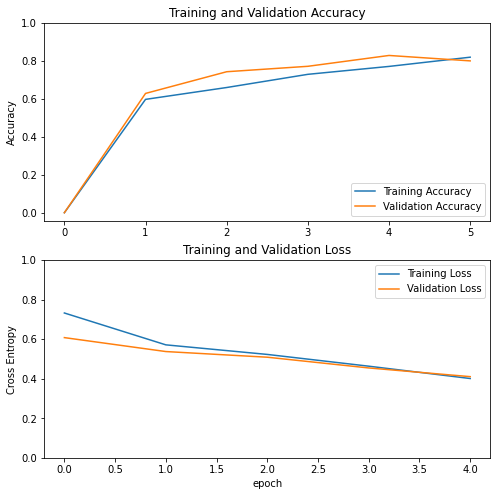

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

base_model = model2.layers[4]
base_model.trainable = True
# look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
5/5 [==============================] - 42s 2s/step - loss: 1.0564 - accuracy: 0.6806 - val_loss: 0.5527 - val_accuracy: 0.6286
Epoch 6/10
5/5 [==============================] - 34s 2s/step - loss: 0.4348 - accuracy: 0.7708 - val_loss: 0.2082 - val_accuracy: 0.9143
Epoch 7/10
5/5 [==============================] - 34s 2s/step - loss: 0.2376 - accuracy: 0.9097 - val_loss: 0.0595 - val_accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 34s 2s/step - loss: 0.1280 - accuracy: 0.9514 - val_loss: 0.2453 - val_accuracy: 0.9429
Epoch 9/10
5/5 [==============================] - 34s 2s/step - loss: 0.1356 - accuracy: 0.9653 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 10/10
5/5 [==============================] - 34s 2s/step - loss: 0.1192 - accuracy: 0.9861 - val_loss: 0.0089 - val_accuracy: 1.0000


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

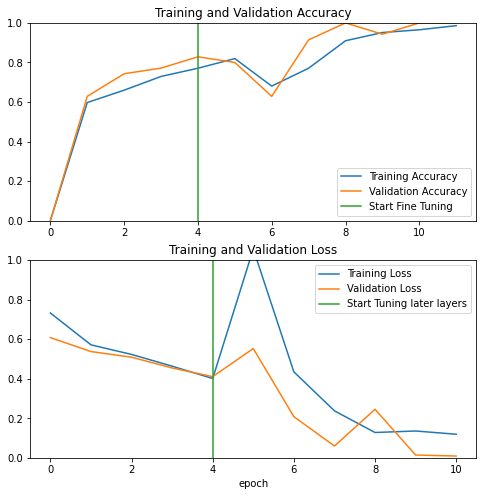

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Tuning later layers')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
! ls ./drive/MyDrive/X-Ray/OK_images_jpeg_cropped/ | wc -l

113


In [ ]:
! ls ./drive/MyDrive/X-Ray/bodyply_cropped/ | wc -l

66
